# Predição de Série Temporal com RNN - Kaggle Stock Market Dataset

Neste notebook vamos:
1. Baixar e carregar o dataset de mercado de ações do Kaggle.
2. Explorar e descrever suas colunas.
3. Escolher uma métrica apropriada para avaliação do modelo.
4. Implementar uma Rede Neural Recorrente (RNN) para prever preços futuros.
5. Avaliar os resultados e plotar valores reais vs. previstos.

In [1]:
# Instalação e download do dataset
!pip install kagglehub --quiet
import kagglehub

# Download do dataset
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")
print("Path to dataset files:", path)

100%|██████████| 522M/522M [00:03<00:00, 163MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2


In [28]:
# Carregando os dados
import pandas as pd

# Altere o caminho para outro ticker caso queira (ex: MSFT.csv, AMZN.csv)
file_path = "/root/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2/stocks/AAPL.csv"
df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


# Descrição das colunas

O dataset contém as seguintes colunas:

- **Date**: Data da negociação.
- **Open**: Preço de abertura do dia.
- **High**: Preço máximo do dia.
- **Low**: Preço mínimo do dia.
- **Close**: Preço de fechamento do dia.
- **Adj Close**: Preço de fechamento ajustado (considerando dividendos e splits).
- **Volume**: Número de ações negociadas no dia.

Neste notebook vamos prever o **Close** (preço de fechamento).

In [29]:
# Pré-processamento inicial
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
data = df[["Date", "Close"]].reset_index(drop=True)
data.head()

,Date,Close
0,1980-12-12,0.513393
1,1980-12-15,0.486607
2,1980-12-16,0.450893
3,1980-12-17,0.462054
4,1980-12-18,0.475446


# Escolha da Métrica

A métrica escolhida será **RMSE (Root Mean Squared Error)**, pois:
- Mede a raiz do erro quadrático médio entre valores previstos e reais.
- Penaliza erros grandes de forma mais severa (bom para preços financeiros).
- É intuitiva, pois está na mesma escala do preço previsto.

In [30]:
# Normalização e criação das sequências de treino/teste
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normaliza os valores de fechamento para [0, 1]
scaler = MinMaxScaler()
data["Close_scaled"] = scaler.fit_transform(data[["Close"]])

# Função para criar janelas temporais
def create_sequences(values, window=30):
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data["Close_scaled"].values, window_size)

# Split 80/20 em treino e teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Ajusta o shape para [amostras, timesteps, features]
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train.shape, X_test.shape

((7903, 30, 1), (1976, 30, 1))

In [31]:
# Construção do modelo RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(128, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.1127e-04 - val_loss: 0.0017
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.6983e-06 - val_loss: 8.5000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.6830e-06 - val_loss: 2.8743e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.7333e-06 - val_loss: 4.5977e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4.5862e-06 - val_loss: 6.7625e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.8909e-06 - val_loss: 1.3651e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.7787e-06 - val_loss: 3.9006e-04
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.5619e-06 - val_loss: 1.3083e-04
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.5034e-06 - val_loss: 3.5696e-04
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.1829e-06 - val_loss: 1.1220e-04
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE no conjunto de teste: 0.0100


/tmp/ipython-input-1739596660.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


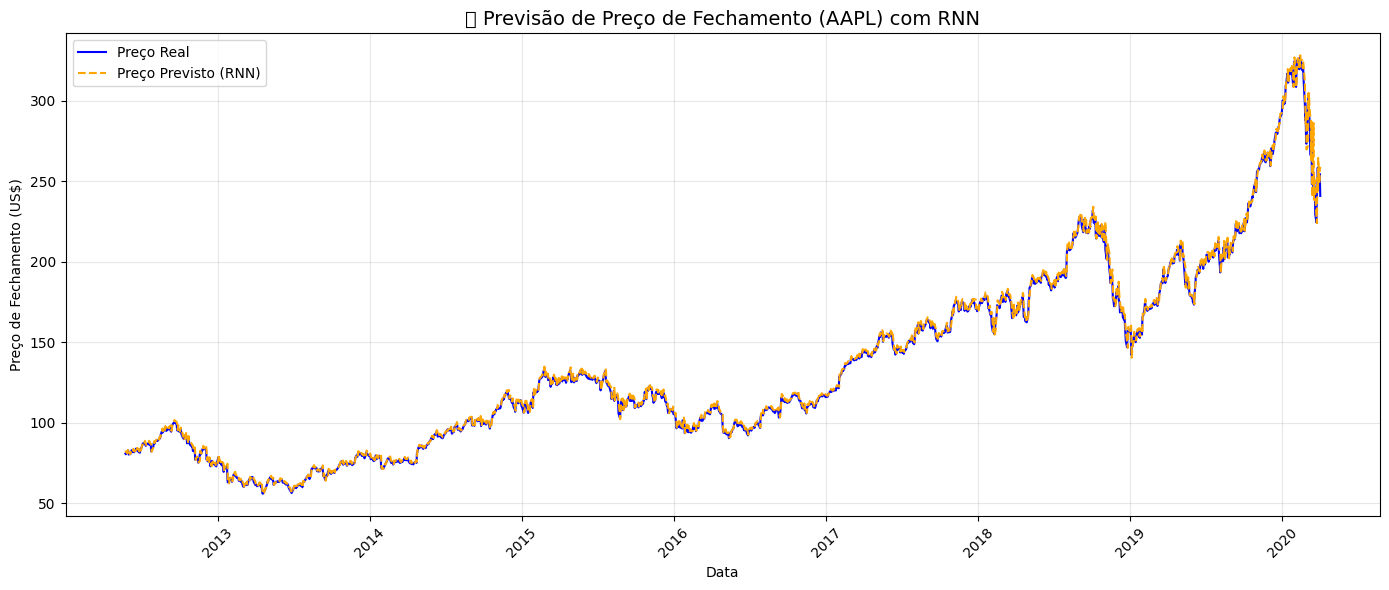

In [33]:
# Avaliação do modelo
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Faz predições
y_pred = model.predict(X_test)

# Calcula RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE no conjunto de teste: {rmse:.4f}")

# Reverte a normalização para valores em dólares
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Recupera as datas correspondentes ao conjunto de teste
dates = data["Date"].values[window_size+split:]

# Plota resultados
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_inv, label="Preço Real", color="blue")
plt.plot(dates, y_pred_inv, label="Preço Previsto (RNN)", color="orange", linestyle="--")
plt.title("📊 Previsão de Preço de Fechamento (AAPL) com RNN", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento (US$)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()